<a href="https://colab.research.google.com/github/Geckomonc/FundamentosDatos/blob/main/sesiones_practicas/sc_1_Geraldine_Acevedo_Restrepo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación de la fuente de datos y librerías

In [ ]:
# Librerías para instalar

!pip install rlxutils

Descarga automáticamente el dataset “Bank Marketing” desde el repositorio oficial de UCI.



In [ ]:
# Librerías
import urllib.request, zipfile, pandas as pd, io
import seaborn as sns
import matplotlib.pyplot as plt

def load_bank_marketing(variant="main"):
    """
    variant: "main"  -> bank.zip (bank-full.csv)
             "additional" -> bank-additional.zip (bank-additional-full.csv)
    """
    urls = {
        "main": "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip",
        "additional": "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip",
    }
    url = urls[variant]

    # Descargar el ZIP a un archivo temporal
    zip_path, _ = urllib.request.urlretrieve(url)

    # Abrir y localizar el CSV correcto
    with zipfile.ZipFile(zip_path, "r") as z:
        names = z.namelist()
        # candidatos según la variante
        candidates = []
        if variant == "main":
            candidates = [n for n in names if n.lower().endswith("bank-full.csv")]
        else:
            candidates = [n for n in names if n.lower().endswith("bank-additional-full.csv")]

        # fallback por si cambia la estructura
        if not candidates:
            candidates = [n for n in names if n.lower().endswith(".csv")]
            if not candidates:
                raise FileNotFoundError("No se encontró ningún CSV dentro del ZIP.")

        with z.open(candidates[0]) as f:
            df = pd.read_csv(f, sep=';')  # este dataset usa ';' como separador
    return df

df = load_bank_marketing("main")        # bank-full.csv (45211 filas, 16 columnas)


# 1. Introducción

### Breve presentación del problema o pregunta de investigación.

¿Qué características de los clientes influyen más en que un cliente acepte o no suscribir un depósito a plazo fijo?

###Contexto: ¿por qué es relevante este problema?

Las campañas de marketing telefónico son costosas y requieren gran cantidad de recursos humanos. Poder predecir con antelación qué clientes tienen más probabilidad de responder positivamente permite reducir gastos y mejorar la eficiencia.

###Relación entre el problema y la base de datos seleccionada.

El dataset contiene información detallada de campañas telefónicas pasadas (45211 registros con 16 variables) que permiten analizar factores sociodemográficos de los clientes, así como variables propias de la campaña (número de contactos, duración, fecha, entre otros).

# 2. Descripción de la base de datos

In [ ]:
# Visualizar una pequeña muestra de los datos
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# Número de registros y variables
print(f"Número de registros: {df.shape[0]}")
print(f"Número de variables: {df.shape[1]}")

Número de registros: 45211
Número de variables: 17


In [ ]:
# Tipos de datos
print("\nTipos de datos por variable:")
print(df.dtypes.value_counts())


Tipos de datos por variable:
object    10
int64      7
Name: count, dtype: int64


In [ ]:
# Clasificación de variables
categoricas = df.select_dtypes(include=['object']).columns.tolist()
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("🔹 Variables categóricas:")
print("\n".join([f"- {col}" for col in categoricas]))

print("\n🔸 Variables numéricas:")
print("\n".join([f"- {col}" for col in numericas]))

🔹 Variables categóricas:
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- poutcome
- y

🔸 Variables numéricas:
- age
- balance
- day
- duration
- campaign
- pdays
- previous


In [ ]:
# Descripción general
print("\nDescripción de variables numéricas:")
print(df.describe())


Descripción de variables numéricas:
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0

# 3. Análisis inicial de las variables

In [ ]:
# Conteo de valores faltantes ordenado de mayor a menor
faltantes = df.isnull().sum().sort_values(ascending=False)

print("\nConteo de valores faltantes por variable:")
print(faltantes[faltantes > 0])  # Solo muestra variables con al menos un valor faltante


Conteo de valores faltantes por variable:
Series([], dtype: int64)


In [ ]:
# Conteo de valores únicos por variable
print("\nConteo de valores únicos por variable:")
print(df.nunique().sort_values(ascending=False))


Conteo de valores únicos por variable:
balance      7168
duration     1573
pdays         559
age            77
campaign       48
previous       41
day            31
month          12
job            12
poutcome        4
education       4
marital         3
contact         3
loan            2
housing         2
default         2
y               2
dtype: int64


Variables clave seleccionadas

De acuerdo con el objetivo de identificar los factores que influyen en la aceptación de un depósito a plazo fijo, se consideran como variables clave:

- Variables directamente relacionadas con la campaña.

  - duration: duración de la llamada en segundos.

  - pdays: días transcurridos desde el último contacto (−1 indica nunca contactado).

  - previous: número de contactos previos.

  - campaign: número de llamadas en la campaña actual.

  - poutcome: resultado de la campaña anterior.

  - month: mes en el que se realizó el contacto.

- Variables sociodemográficas del cliente

  - age (edad)

  - job (profesión)

  - marital (estado civil)

  - education (nivel educativo)

  - balance (saldo medio anual de la cuenta bancaria)

In [ ]:
# Selección de variables numéricas clave
variables_clave = ['duration', 'pdays', 'previous', 'campaign']

# Vista rápida de las variables clave relacionadas con la campaña
print("Vista rápida de variables clave:")
print(df[variables_clave].head())

# Estadísticas descriptivas de las variables clave relacionadas con la campaña
print("\nEstadísticas descriptivas de variables clave:")
print(df[variables_clave].describe())

Vista rápida de variables clave:
   duration  pdays  previous  campaign
0       261     -1         0         1
1       151     -1         0         1
2        76     -1         0         1
3        92     -1         0         1
4       198     -1         0         1

Estadísticas descriptivas de variables clave:
           duration         pdays      previous      campaign
count  45211.000000  45211.000000  45211.000000  45211.000000
mean     258.163080     40.197828      0.580323      2.763841
std      257.527812    100.128746      2.303441      3.098021
min        0.000000     -1.000000      0.000000      1.000000
25%      103.000000     -1.000000      0.000000      1.000000
50%      180.000000     -1.000000      0.000000      2.000000
75%      319.000000     -1.000000      0.000000      3.000000
max     4918.000000    871.000000    275.000000     63.000000


# 4. Visualizaciones exploratorias básicas

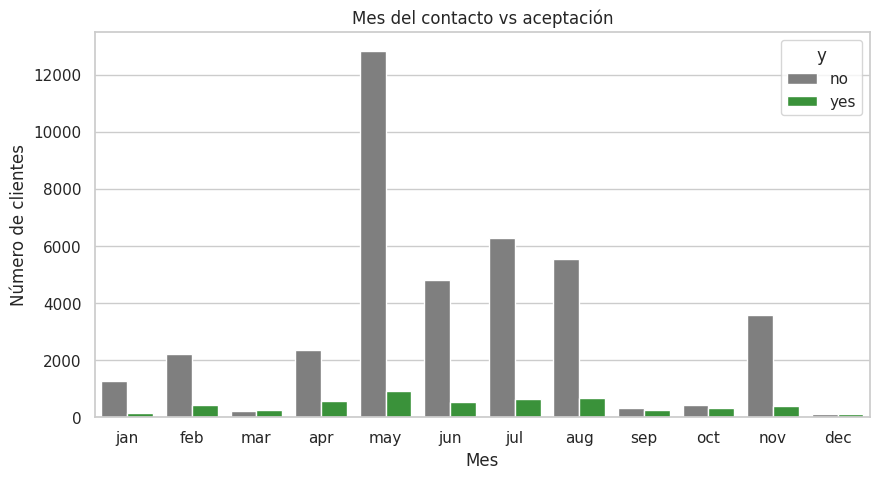

In [ ]:
# mes del último contacto
plt.figure(figsize=(10,5))
sns.countplot(x="month", hue="y", data=df, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
              palette={"yes":"tab:green","no":"tab:gray"})
plt.title("Mes del contacto vs aceptación")
plt.xlabel("Mes")
plt.ylabel("Número de clientes")
plt.show()

<Axes: xlabel='job'>

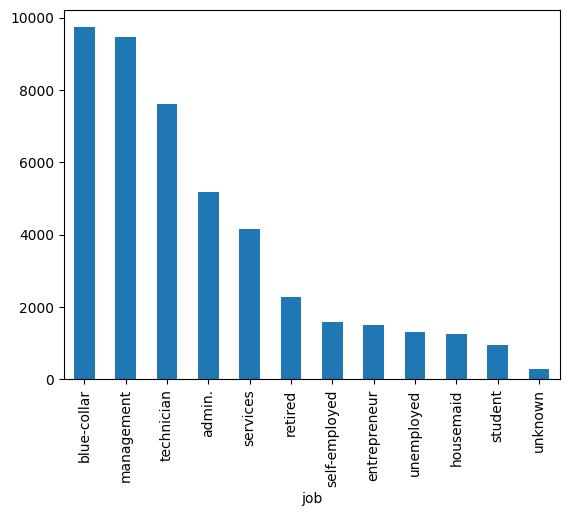

In [ ]:
df.job.value_counts().plot(kind='bar')

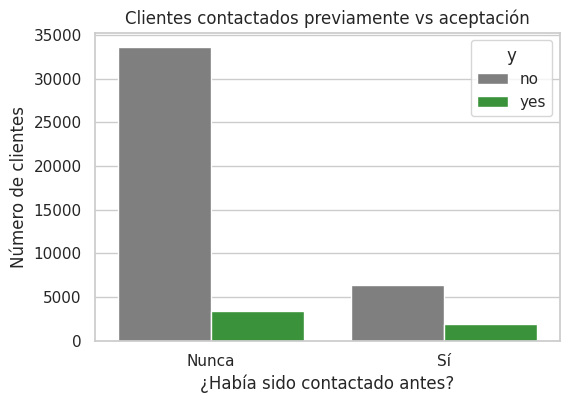

In [ ]:
# PDAYS (días desde último contacto, -1 = nunca)
df['contacted_before'] = df['pdays'].apply(lambda x: "Nunca" if x==-1 else "Sí")
plt.figure(figsize=(6,4))
sns.countplot(x="contacted_before", hue="y", data=df, palette={"yes":"tab:green","no":"tab:gray"})
plt.title("Clientes contactados previamente vs aceptación")
plt.xlabel("¿Había sido contactado antes?")
plt.ylabel("Número de clientes")
plt.show()

/tmp/ipython-input-3482645321.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="y", y="campaign", data=df, palette={"yes":"tab:green","no":"tab:gray"})


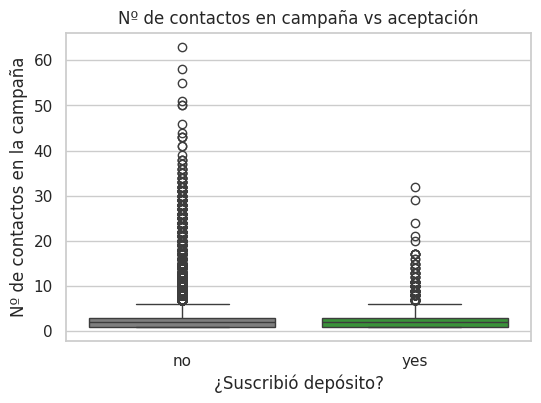

In [ ]:
# CAMPAIGN (nº de contactos en esta campaña)
plt.figure(figsize=(6,4))
sns.boxplot(x="y", y="campaign", data=df, palette={"yes":"tab:green","no":"tab:gray"})
plt.title("Nº de contactos en campaña vs aceptación")
plt.xlabel("¿Suscribió depósito?")
plt.ylabel("Nº de contactos en la campaña")
plt.show()

/tmp/ipython-input-2432797086.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="y", y="previous", data=df, palette={"yes":"tab:green","no":"tab:gray"})


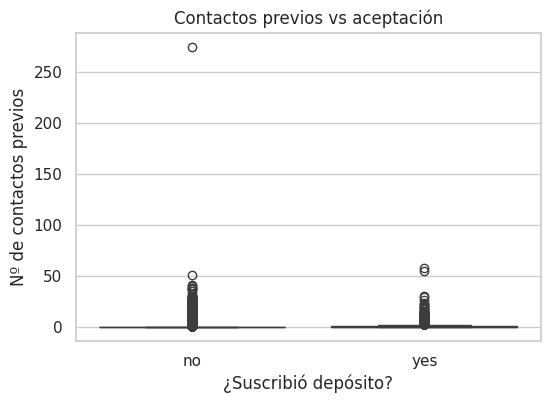

In [ ]:
# PREVIOUS (nº de contactos previos)
plt.figure(figsize=(6,4))
sns.boxplot(x="y", y="previous", data=df, palette={"yes":"tab:green","no":"tab:gray"})
plt.title("Contactos previos vs aceptación")
plt.xlabel("¿Suscribió depósito?")
plt.ylabel("Nº de contactos previos")
plt.show()

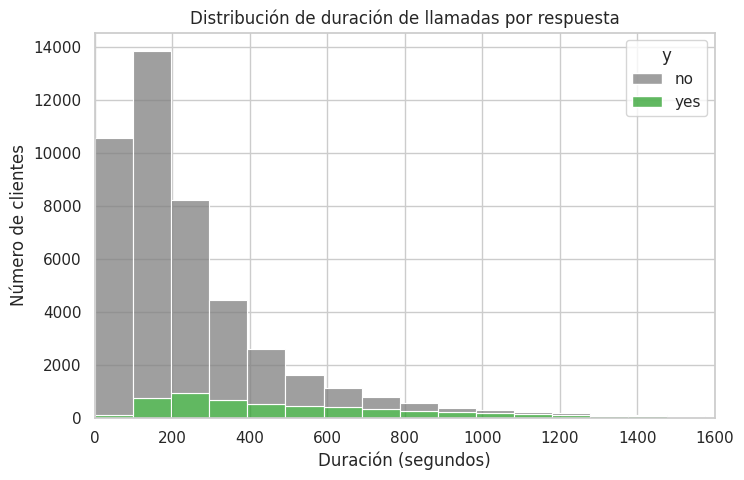

In [ ]:
# Distribución de duración de llamadas por respuesta
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="duration", hue="y", bins=50,
             palette={"yes":"tab:green","no":"tab:gray"},
             multiple="stack")
plt.title("Distribución de duración de llamadas por respuesta")
plt.xlabel("Duración (segundos)")
plt.ylabel("Número de clientes")
plt.xlim(0, 1600)
plt.show()

<Axes: xlabel='education'>

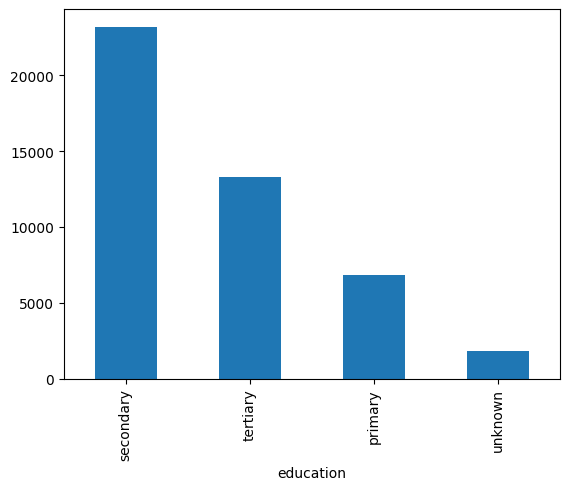

In [ ]:
df.education.value_counts().plot(kind='bar')

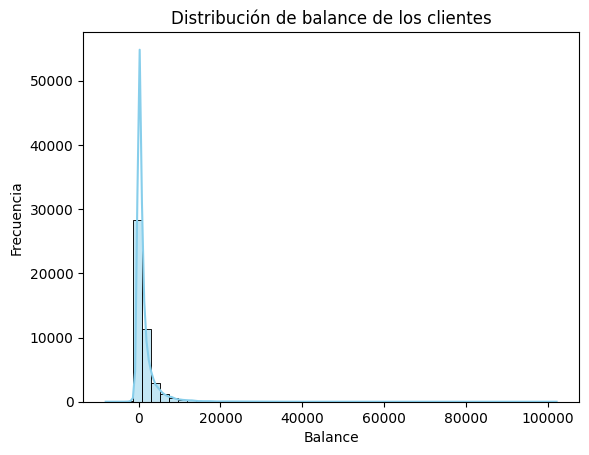

In [ ]:
# Histograma: distribución de balance
sns.histplot(df['balance'], bins=50, kde=True, color='skyblue')
plt.title("Distribución de balance de los clientes")
plt.xlabel("Balance")
plt.ylabel("Frecuencia")
plt.show()

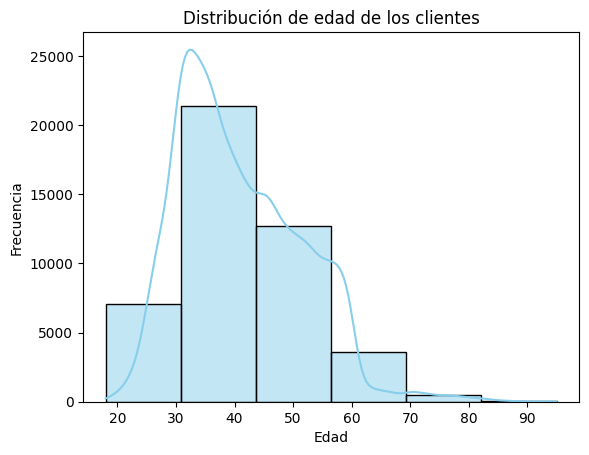

In [ ]:
# Histograma: distribución de edad
sns.histplot(df['age'], bins=6, kde=True, color='skyblue')
plt.title("Distribución de edad de los clientes")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

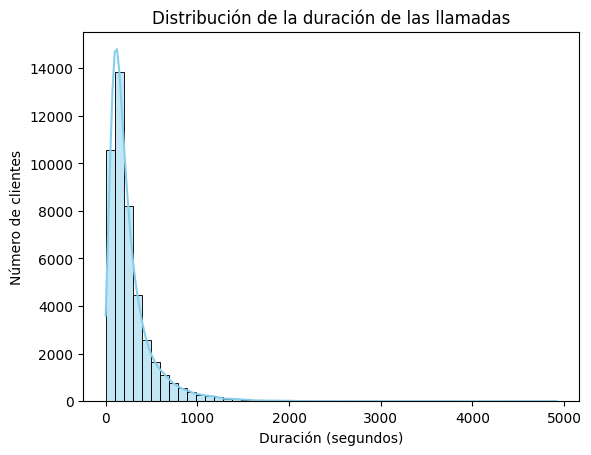

In [ ]:
# Histograma: distribución de duración de la llamada
sns.histplot(df['duration'], bins=50, kde=True, color='skyblue')
plt.title("Distribución de la duración de las llamadas")
plt.xlabel("Duración (segundos)")
plt.ylabel("Número de clientes")
plt.show()

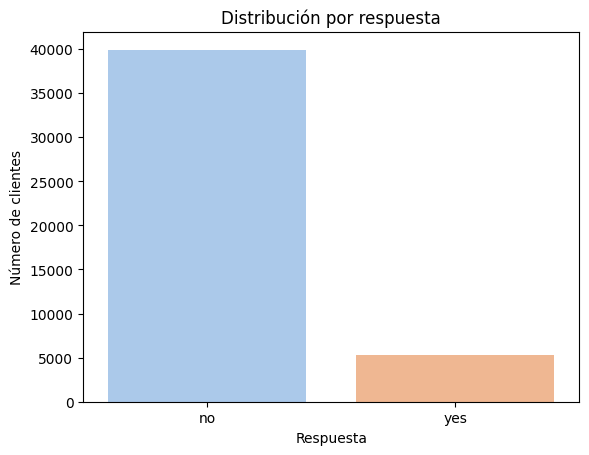

In [ ]:
# Gráfico de barras: respuesta
sns.countplot(x='y', data=df,hue='y', palette='pastel',legend=False)
plt.title("Distribución por respuesta")
plt.xlabel("Respuesta")
plt.ylabel("Número de clientes")
plt.show()

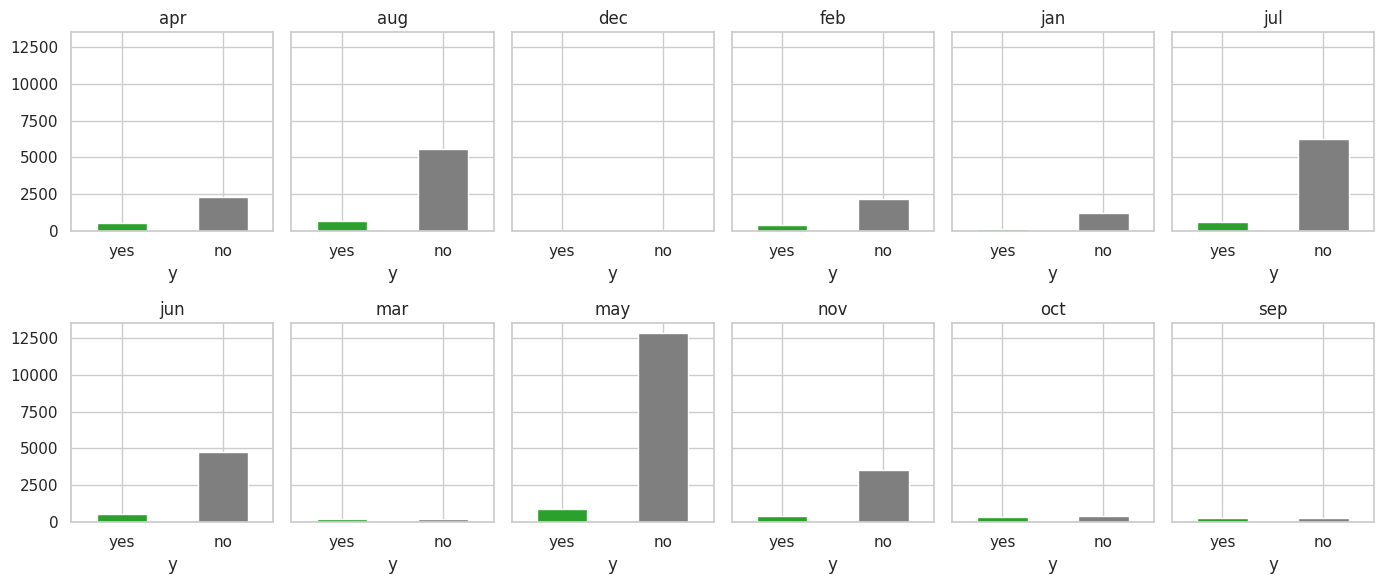

In [ ]:
c = sorted(df['month'].unique())
fig, axes = plt.subplots(2, 6, figsize=(14,6), sharey=True)  # misma escala Y
axes = axes.ravel()

for i, ci in enumerate(c):
    zc = df[df['month'] == ci]
    counts = zc.y.value_counts().reindex(['yes','no'], fill_value=0)
    counts.plot(kind='bar', ax=axes[i], color=['tab:green','tab:gray'])
    axes[i].set_title(ci)
    axes[i].set_xticklabels(['yes','no'], rotation=0)

plt.tight_layout()
plt.show()

# 5. Interpretaciones iniciales

### ¿Qué tendencias o patrones básicos se observan?

- En la variable de edad (age) la distribución está centrada entre 30 y 50 años. La mayoría de clientes están en ese rango.

- En la variable de balance (balance) la mayoría de clientes tienen balances bajos o cercanos a 0.

- En la variable de duración (duration) la gran mayoría de llamadas son cortas (menos de 500 segundos). Cuando la llamada es más larga, aumenta la probabilidad de aceptación (yes).

- En la variable de pdays (pdays) la mayoría de clientes nunca habían sido contactados antes (valor = -1). Esto significa que “primer contacto” es lo más común.

- En la variable poutcome (poutcome) cuando el resultado de campañas previas fue “success”, la tasa de aceptación es mucho mayor.

### ¿Qué limitaciones tiene la base de datos?

- Desbalance en la variable objetivo: hay muchos más “no” que “yes”. Esto puede afectar un futuro modelo predictivo.

- Las variables que solo están disponibles post-llamada como lo es duration es muy predictiva, pero solo se conoce después de haber llamado, entonces no es útil para segmentar antes de la campaña.

- Los valores faltantes “unknown” en variables como education, job o contact hay registros con valor desconocido, lo que puede afectar el analisis.

### ¿Qué hipótesis iniciales podrían plantearse para análisis posteriores?

- Los clientes con llamadas más largas tienen mayor probabilidad de aceptar el depósito.

- Características sociodemográficas (nivel educativo, tipo de empleo) influyen en la decisión final.

- Los clientes con historial positivo en campañas previas (poutcome=success) presentan mayor propensión a decir “yes”.

# 6. Conclusiones

Se identificaron patrones relevantes:

- Las llamadas más largas aumentan la probabilidad de aceptación.

- El éxito en campañas previas incrementa la respuesta positiva.

- La mayoría de clientes nunca había sido contactada antes y presentan baja aceptación.

Las visualizaciones exploratorias muestran:

- Clientes principalmente entre 30 y 50 años.

- Predominio de educación secundaria y empleos blue-collar, management y technician.

Limitaciones del dataset:

- Desbalance de respuesta (“no” ,  “yes”).

- Algunas variables clave (ej. duration) solo se conocen después de la llamada.

# 7. Referencias
- Fuente(s) de los datos.
- Cualquier referencia bibliográfica o técnica utilizada.

Fuente de los datos

Dataset: Bank Marketing

Autores: S. Moro, P. Rita, P. Cortez

Descripción: Este dataset corresponde a los registros de campañas de marketing directo de una institución bancaria portuguesa. Las campañas se realizaron principalmente a través de llamadas telefónicas, con el objetivo de convencer a los clientes de suscribir un depósito a plazo fijo.